# Intro:
    1. train_dataset of type IterableDataset for streaming data with no sampler. 
    2. Datasets used: mnli, xnli, snli. These are combined to a common format into train_dataset.
    3. eval_dataset and test_dataset: map type datasets for random/sequential sampler
    4. Error in the automatic Trainer api at the end of eval step throws error <KeyError: 'eval_loss'>
    5. Hence manually training now

In [1]:
# !pip install --upgrade transformers
# !pip install datasets
# !pip install --upgrade seaborn

In [55]:
import os
import seaborn as sns
import numpy as np
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import transformers
import tokenizers
import datetime
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

from datasets import load_dataset
import torch
from transformers import BertTokenizer, AutoTokenizer, TrainingArguments
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [4]:
mnli = load_dataset('glue', 'mnli')
len (mnli)

Reusing dataset glue (C:\Users\almug\.cache\huggingface\datasets\glue\mnli\1.0.0\7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)


5

In [5]:
xnli = load_dataset('xnli', 'all_languages')
len (xnli)

Reusing dataset xnli (C:\Users\almug\.cache\huggingface\datasets\xnli\plain_text\1.0.0\95e1793728642389d5c4f86e1bd48f6d1bb9e867c7f74a0f7ae4156a09255c46)


2

In [6]:
# ignore snli as it gave poor accuracy
# snli = load_dataset('snli')
# len (snli)

Reusing dataset snli (C:\Users\almug\.cache\huggingface\datasets\snli\plain_text\1.0.0\bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c)


3

In [7]:
# shuffle and randomly sample 25% as dev/valid and rest 75% as train
original_train_df = pd.read_csv ("../input/contradictory-my-dear-watson/train.csv")
original_train_df = shuffle (original_train_df)
print (original_train_df.shape)
original_valid_df = original_train_df[:len(original_train_df)//4]
original_train_df = original_train_df[(len(original_train_df)//4):]
print (original_train_df.shape, original_valid_df.shape)
original_train_df.head()

(12120, 6)
(9090, 6) (3030, 6)


,id,premise,hypothesis,lang_abv,language,label
567,18b1750cb6,یہاں تک کہ اگر مقدمہ واپس لینے کی اجازت ہوتی ب...,ہوسکتا ہے اٹارنی کو خسارہ اٹھانا پڑے یہاں تک ا...,ur,Urdu,0
1325,04f30501e7,those little kids don't understand it,Those young children can't comprehend it.,en,English,0
8230,003868a77d,"Я сказал, что это наша единственная возможност...",Возможность была тогда и сейчас.,ru,Russian,0
10506,ed7492a6b6,"Locust Hill, добре, страхотно",Локуст Хил е най-доброто място.,bg,Bulgarian,1
4919,cf7d83d61f,"Sitting up at night is always rather jumpy, sh...","She stated, ""Sitting up at night is relaxing.""",en,English,2


In [8]:
original_test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
original_test_df.shape

(5195, 5)

In [67]:
bert_model_name = 'bert-base-multilingual-cased'
max_len   = 128
tokenizer = BertTokenizer.from_pretrained (bert_model_name, do_lower_case=False)

bert_model_name = 'xlm-roberta-large'
max_len   = 128
tokenizer = AutoTokenizer.from_pretrained (bert_model_name)

In [68]:
def encode (premise, hypothesis, label):
    
    encoded_dict = tokenizer (
                        premise,                   # 1st of the Sentence pair to encode.
                        hypothesis,                # 2nd of the Sentence pair to encode. 
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,           # just max_len will not automatically truncate
                        max_length = max_len,      # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
    ) 
    # print ('encoded_dict =', encoded_dict)
    # 1-D tensors are expected for a sample. Hence squeeze these 2-D tensors e.g [1,256] shaped tensors to 1-D [256] shape 
    for k in encoded_dict:
        encoded_dict[k] = torch.squeeze (encoded_dict[k])
    encoded_dict['labels'] = label
    # encoded_dict['lang'] = lang
    return encoded_dict

In [69]:
def _get_features(elt):
    '''
    Args:
        elt: elements of a `nlp.arrow_dataset.Dataset` that we have seen above
    
    Yields: tuples of 3 elements: (premise, hypothesis, language)
    '''

    if type(elt) == pd.core.series.Series:
        yield (elt['premise'], elt['hypothesis'], elt['lang_abv'])
    
    elif type(elt['premise']) == str:  
        yield (elt['premise'], elt['hypothesis'], 'en')
    
    elif type(elt) == dict:
        
        # dict of strings
        premises = elt['premise']
        
        # dict of lists
        hypotheses_dict = elt['hypothesis']
        
        # lists
        langs = hypotheses_dict['language']
        translations = hypotheses_dict['translation']
        
        hypotheses = {k: v for k, v in zip(langs, translations)}
                
        for lang in elt['premise']:
            if lang in hypotheses:
                yield (elt['premise'][lang], hypotheses[lang], lang)
    return
        
def _get_raw_datasets_from_nlp(ds):
    """ From a `ds: nlp.arrow_dataset.Dataset` that we have seen above to a generator of dictionaries with unified format.
    
    Yield a dictionary with keys: 'premise', 'hypothesis', 'label', 'lang'
    """
    
    for _, elt in enumerate(ds):
        
        label = -1
        if 'label' in elt:
            label = elt['label']
        for features in _get_features(elt):    
            # yield {'premise': features[0], 'hypothesis': features[1], 'label': label, 'lang': features[2]}
            yield (encode (features[0], features[1], torch.tensor(label))) #, features[2]))
    return
            
def _get_raw_datasets_from_dataframe(ds: pd.core.frame.DataFrame):
    """
    ds: pd.core.frame.DataFrame
    """
    
    result = []
    
    for idx, elt in ds.iterrows():
        for features in _get_features(elt):
            
            label = -1
            if 'label' in elt:
                label= elt['label']            
            # yield (encode {'premise': features[0], 'hypothesis': features[1], 'label': label, 'lang': features[2]})
            yield (encode (features[0], features[1], torch.tensor(label))) #, features[2]))
    return

In [70]:
raw_ds_mapping = {
    'original train': (_get_raw_datasets_from_dataframe, original_train_df, len(original_train_df)),
    'original valid': (_get_raw_datasets_from_dataframe, original_valid_df, len(original_valid_df)),
    'snli train'    : (_get_raw_datasets_from_nlp, snli['train'], snli['train'].num_rows),
    'snli valid'    : (_get_raw_datasets_from_nlp, snli['validation'], snli['validation'].num_rows),
    'mnli train'    : (_get_raw_datasets_from_nlp, mnli['train'], mnli['train'].num_rows),
    'mnli valid 1'  : (_get_raw_datasets_from_nlp, mnli['validation_matched'], mnli['validation_matched'].num_rows),
    'mnli valid 2'  : (_get_raw_datasets_from_nlp, mnli['validation_mismatched'], mnli['validation_mismatched'].num_rows),
    'xnli valid'    : (_get_raw_datasets_from_nlp, xnli['validation'], xnli['validation'].num_rows * 15), # 15 languages
    'xnli test'     : (_get_raw_datasets_from_nlp, xnli['test'], xnli['test'].num_rows * 15), # 15 languages
    'original test' : (_get_raw_datasets_from_dataframe, original_test_df, len(original_test_df)),
}

def get_raw_dataset(ds_name):
    
    fn, ds, nb_examples = raw_ds_mapping[ds_name]
    for x in fn(ds):
        yield x
    return

In [71]:
# sanity check
for k in raw_ds_mapping:
    for idx, x in enumerate(get_raw_dataset(k)):
        print (x)
        print (x['input_ids'].shape)
        if idx >= 0:
            break

{'input_ids': tensor([   101,  63839,  22880,  15333,  25516,    788,  43348,  11242,    791,
         10429,  79144,  80044,  19878,  11076,  82846,  62823,  17047,  23458,
           752,  23458,  16152,    791,  18716,  10961,  13244,    763,  61783,
         19445,  10278,    772,  68513,  26973, 106582,  11689,    788,  56765,
         11145,  36793,  21735,  15896,  11091,  60312,  10429,  10861,  13141,
         40160,  10429,  40302,  15714,  11076,    789,  14495,  40302,  75389,
         77300,  10861,  12218,    764,  10658,  11693,  48794,  16163,  10691,
           771,  98273,  12009,  11689,    837,    102,  18779,  11091,  60312,
         10429,  10861,    763,  38894,  45603,  10278,  13244,    770,  91433,
         11242,    763,  85484,  37641,    817,  48941,  63839,  22880,  25516,
         21035,  11076,  11091,  11689,    829,  15714, 103350,  14014,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

In [72]:
train_ds_names = ['original train', 'mnli train', 'mnli valid 1', 'mnli valid 2', 'xnli valid', 'xnli test']
eval_ds_names  = ['original valid']
test_ds_names  = ['original test']

In [73]:
class MyIterableDataset (torch.utils.data.IterableDataset):
    
    def __init__(self, ds_names, isLabeledDataset=False):
        
        super (MyIterableDataset).__init__()
        self.ds_names = ds_names
        self.length   = self.getLen ()
        self.isLabeledDataset = isLabeledDataset
        return
    
    def getLen (self):
        
        length = 0
        for ds_name in self.ds_names:
            
            fn, ds, nb_examples = raw_ds_mapping[ds_name]
            length += nb_examples
        return length  # 64
    
    def __iter__(self):
        
        # junk = 0
        for ds_name in self.ds_names:
            
            fn, ds, nb_examples = raw_ds_mapping[ds_name]
            for x in fn(ds):
                # strangely sometimes label is not found i.e label=-1 by default, so filter such instanes
                if self.isLabeledDataset and x['labels'] == -1:
                    continue
                # junk += 1
                # if junk >=64:
                #     return
                yield x
        return
    
    def __len__(self):
        return self.length

In [74]:
# total count = 1018941, valid count i.e where label != -1, is = 1017997 i.e 944 bad data records
train_dataset = MyIterableDataset (train_ds_names, True)

# sanity test
# this will not work since __getitem__() is not implemented in MyIterableDataset
# print (train_dataset[0])
for i, d in enumerate (train_dataset):
    if i==0:
        print (d)
        break

{'input_ids': tensor([   101,  63839,  22880,  15333,  25516,    788,  43348,  11242,    791,
         10429,  79144,  80044,  19878,  11076,  82846,  62823,  17047,  23458,
           752,  23458,  16152,    791,  18716,  10961,  13244,    763,  61783,
         19445,  10278,    772,  68513,  26973, 106582,  11689,    788,  56765,
         11145,  36793,  21735,  15896,  11091,  60312,  10429,  10861,  13141,
         40160,  10429,  40302,  15714,  11076,    789,  14495,  40302,  75389,
         77300,  10861,  12218,    764,  10658,  11693,  48794,  16163,  10691,
           771,  98273,  12009,  11689,    837,    102,  18779,  11091,  60312,
         10429,  10861,    763,  38894,  45603,  10278,  13244,    770,  91433,
         11242,    763,  85484,  37641,    817,  48941,  63839,  22880,  25516,
         21035,  11076,  11091,  11689,    829,  15714, 103350,  14014,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

In [75]:
# create a custom map type dataset
class My_Dataset (torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        
        self.encodings = encodings
        self.labels = labels
        return

    def __getitem__(self, idx):
        
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None and len (self.labels)>0:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [76]:
def get_mapType_Dataset (ds_names, isLabeledDataset):
    
    # test/eval dataset is not supposed to be infinite i.e generator/iterable dataset. 
    # It has to be an ordinary dataset which is based on a sampler. Hence, convert to an ordinary dataset
    input_ids          = []
    token_type_ids     = []
    attention_mask     = []
    labels             = []
    lang               = []
    dataset_iter  = MyIterableDataset (ds_names, isLabeledDataset)
    for encoded_dict in dataset_iter:
        
        input_ids.append (encoded_dict['input_ids'])
        token_type_ids.append (encoded_dict['token_type_ids'])
        attention_mask.append (encoded_dict['attention_mask'])
        labels.append (encoded_dict['labels'])
        # lang.append (encoded_dict['lang'])

    # Combine the training inputs into a TensorDataset. This arranges a row as a tuple of tensors.
    # Convert the lists into tensors.
    # input_ids = torch.cat (input_ids, dim=0)
    # attention_mask = torch.cat (attention_mask, dim=0)
    # token_type_ids = torch.cat (token_type_ids, dim=0)
    # label = torch.tensor (label)
    # But this works only in manually training the model because then you assign each element of the tuple 
    # to the corresponding model params. In the trainer you need to assign your custom map type dataset
    # my_dataset = TensorDataset (input_ids, attention_mask, token_type_ids, label)
    
    encodings  = {'input_ids':input_ids, 'attention_mask':attention_mask, 'token_type_ids':token_type_ids}
    my_dataset = My_Dataset (encodings,  labels)
    return my_dataset

In [77]:
eval_dataset = get_mapType_Dataset (eval_ds_names, True)
test_dataset = get_mapType_Dataset (test_ds_names, False)

In [78]:
len (train_dataset), len (eval_dataset), len (test_dataset), isinstance (train_dataset, torch.utils.data.IterableDataset), isinstance (test_dataset, torch.utils.data.IterableDataset)

(64, 63, 63, True, False)

In [79]:
# sanity test
for i, row in enumerate (test_dataset):
    print (row)
    if i >=0:
        break

{'input_ids': tensor([  101,   764, 28744,   752, 11076, 16577,   752, 10748, 67499, 10961,
          752,   834, 82397, 17317, 11242,   752, 11076, 16161,   752, 11076,
        16161,   752, 11363, 13244, 22887, 76528,   829, 32245, 11722, 85408,
        10691, 86325, 77970, 10429, 10691, 12995, 11689,   764, 28744, 13378,
        13244, 29847,   774, 10658, 17651, 65176, 75399, 21516, 12574, 11722,
        11285, 43164, 32326, 23780,   823, 25908, 11145, 12687,   102, 11076,
        16577, 10691,   787, 26649, 40634, 59360, 50717, 21735, 18779, 47238,
          117, 13244, 22887, 12710,   829, 32245, 11722, 85408, 10691, 69883,
        23172, 13378, 10916, 11689, 12427, 13141,   788, 10673, 17571,   119,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

# My Trainer

In [80]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
def save_my_model_and_tokenizer (model, tokenizer=None, output_dir='./model_save/'):
    """
    to load the saved model just do: 
    model     = BertForSequenceClassification.from_pretrained (output_dir)
    tokenizer = BertTokenizer.from_pretrained (output_dir, do_lower_case=False)
    """
    
    # Create output directory if needed
    if not os.path.exists (output_dir):
        os.makedirs (output_dir)

    print ("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model.cpu ()
    model_to_save = model.module if hasattr (model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained (output_dir)
    if tokenizer is not None:
        tokenizer.save_pretrained (output_dir)
    model.cuda ()
    
    # Good practice: save your training arguments together with the trained model
    # torch.save(args, os.path.join(output_dir, 'training_args.bin'))
    return

In [81]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

In [82]:
def compute_metrics (labels, pred_logits):
    
    preds = pred_logits.argmax (-1)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc = accuracy_score (labels, preds)
    mcc = matthews_corrcoef (labels, preds)        # matthews correlation coefficient
    metrics = {
        'mcc': mcc,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    return metrics

In [1]:
class MyTrainer:
    
    def __init__(self, model, args, train_dataset, eval_dataset, tokenizer, compute_metrics=compute_metrics):
        
        self.model           = model
        self.args            = args
        self.train_dataset   = train_dataset
        self.eval_dataset    = eval_dataset
        self.tokenizer       = tokenizer
        self.compute_metrics = compute_metrics
        self.isTrained       = False
        self.device          = self.get_device_type ()
        
        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW (model.parameters (),
                           lr  = args.learning_rate,
                           eps = args.adam_epsilon # args.adam_epsilon  - default is 1e-8 is “a very small number to prevent any division by zero"
        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        self.epochs = self.args.num_train_epochs
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps = self.get_dataLoaders ()        
        return
    
    def get_device_type (self):
        
        # If there's a GPU available...
        if torch.cuda.is_available ():    

            # Tell PyTorch to use the GPU.    
            device = torch.device ("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count ())

            print('We will use the GPU:', torch.cuda.get_device_name(0))
        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device ("cpu")
        return device
    
    def get_dataLoaders (self):        
        
        # Create the DataLoaders for our training and validation sets.
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = SequentialSampler (self.train_dataset)
        train_dataloader = DataLoader (
                    self.train_dataset,  # The training samples.
                    sampler = train_sampler,
                    batch_size = self.args.per_device_train_batch_size  # Trains with this batch size.
        )
        
        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader (
                    self.eval_dataset,             # The validation/dev samples.
                    sampler = SequentialSampler (self.eval_dataset),
                    batch_size = self.args.per_device_eval_batch_size  # Evaluate with this batch size.
        )
        
        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        num_training_steps = len (train_dataloader) * self.epochs

        # Create the learning rate scheduler.
        lr_scheduler = get_linear_schedule_with_warmup (self.optimizer, 
                                                        num_warmup_steps   = self.args.num_warmup_steps, # Default value in run_glue.py
                                                        num_training_steps = num_training_steps)
        return train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
    
    
    def test_iterate_dataloader ():
        
        for step, batch in enumerate (self.train_dataloader):
            print (step, batch)
        return
    
    
    def train (self, is_train_base_encoding_model=True):
        
        # for tuning only the outer classifier layar and not the base bert encoding layer
        if not is_train_base_encoding_model:
            for param in self.model.base_model.parameters ():
                param.requires_grad = False
        
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

        # Set the seed value all over the place to make this reproducible.
        seed_val = 42
        random.seed (seed_val)
        np.random.seed (seed_val)
        torch.manual_seed (seed_val)
        torch.cuda.manual_seed_all (seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []
        # Measure the total training time for the whole run.
        total_t0 = time.time ()
        # inint min_val_loss to a large val, if after each epoch eval-loss < min_val_loss, then save the model
        min_val_loss = 99999999
        step = 0
        
        # For each epoch...
        for epoch_i in range (0, self.epochs):

            # ========================================
            #               Training
            # ========================================

            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time ()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.model.train ()

            # For each batch of training data...
            for stp, batch in enumerate (self.train_dataloader):

                step += 1
                # Progress update every 40 batches.
                # print ('batch =', batch)
                if step % 50 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = format_time (time.time() - t0)

                    # Report progress.
                    print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len (self.train_dataloader), elapsed))
                if (self.args.max_steps > 0 and self.args.max_steps < step) or  \
                   (is_train_base_encoding_model and self.args.eval_steps>0 and step % self.args.eval_steps==0 and step>0):
                    
                    avg_train_loss = total_train_loss / step
                    training_time = format_time (time.time () - t0)
                    print ("Running Validation...")
                    avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
                    training_stats.append ({
                            'epoch'         : epoch_i + 1,
                            'training_loss' : avg_train_loss,
                            'eval_loss'     : avg_val_loss,
                            'eval_f1'       : avg_val_f1,
                            'eval_mcc'      : avg_val_mcc, 
                            'eval_precision': avg_val_precision,
                            'eval_recall'   : avg_val_recall,
                            'eval_accuracy' : avg_val_accuracy,
                            'training_time' : training_time,
                            'eval_time'     : validation_time                   
                    })
                    # save this model if the eval loss decreases from the minimum so far
                    if avg_val_loss < min_val_loss: 

                        min_val_loss = avg_val_loss
                        save_my_model_and_tokenizer (self.model, self.tokenizer, output_dir='./model_save/')

                # Unpack this training batch from our dataloader. 
                #
                # As we unpack the batch, we'll also copy each tensor to the GPU using the 
                # `to` method.
                #
                # `batch` contains four pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: segment_ids
                #   [3]: labels 
                # b_input_ids = batch[0].to(device)
                # b_input_mask = batch[1].to(device)
                # b_segment_ids = batch[2].to(device)
                # b_labels = batch[3].to(device)

                # Always clear any previously calculated gradients before performing a
                # backward pass. PyTorch doesn't do this automatically because 
                # accumulating the gradients is "convenient while training RNNs". 
                # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
                self.model.zero_grad ()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                # loss, logits = self.model (b_input_ids, 
                #                            token_type_ids=b_segment_ids, 
                #                            attention_mask=b_input_mask, 
                #                            labels=b_labels)
                for k in batch:
                    batch[k] = batch[k].to (self.device)
                output = self.model (**batch)
                loss   = output.loss
                logits = output.logits
                
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item ()

                # Perform a backward pass to calculate the gradients.
                loss.backward ()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step ()

                # Update the learning rate.
                self.lr_scheduler.step ()
            
            # if self.args.eval_steps <= 0:
            # At the end of each epoch measure stats and eval:
            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len (self.train_dataloader)
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print("  Average training loss: {0:.2f}".format (avg_train_loss))
            print("  Training epcoh took: {:}".format (training_time))
            print ("\n  Running Validation...")
            avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
            
            # Record all statistics from this epoch.
            training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_train_loss,
                    'eval_loss'     : avg_val_loss,
                    'eval_f1'       : avg_val_f1,
                    'eval_mcc'      : avg_val_mcc, 
                    'eval_precision': avg_val_precision,
                    'eval_recall'   : avg_val_recall,
                    'eval_accuracy' : avg_val_accuracy,
                    'training_time' : training_time,
                    'eval_time'     : validation_time                   
            })
            # save this epoch's model if the eval loss decreases from the minimum so far
            if avg_val_loss < min_val_loss:
                
                min_val_loss = avg_val_loss
                save_my_model_and_tokenizer (self.model, self.tokenizer, output_dir='./model_save/')
        
        print ("")
        print ("Training complete!")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.plot_train_stats (training_stats)
        return training_stats
    
    def evaluate (self):
        
        t0 = time.time ()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains four pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: segment_ids
            #   [3]: labels 
            # b_input_ids = batch[0].to (device)
            # b_input_mask = batch[1].to (device)
            # b_segment_ids = batch[2].to (device)
            # b_labels = batch[3].to (device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad ():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                # output = self.model (b_input_ids, 
                #                      token_type_ids=b_segment_ids, 
                #                      attention_mask=b_input_mask,
                #                      labels=b_labels)
                for k in batch:
                    batch[k] = batch[k].to (self.device)
                output = self.model (**batch)
                loss   = output.loss
                logits = output.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item ()

            # Move logits and labels to CPU
            logits    = logits.detach ().cpu ().numpy ()
            label_ids = batch['labels'].to ('cpu').numpy ()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            metrics = self.compute_metrics (label_ids, logits)
            total_eval_mcc       += metrics['mcc']
            total_eval_f1        += metrics['f1']
            total_eval_precision += metrics['precision']
            total_eval_recall    += metrics['recall']
            total_eval_accuracy  += metrics['accuracy']


        # Report the final accuracy for this validation run.
        avg_val_f1 = total_eval_f1 / len (self.validation_dataloader)
        print ("  F1: {0:.3f}".format (avg_val_f1))
        avg_val_mcc = total_eval_mcc / len (self.validation_dataloader)
        print ("  MCC: {0:.3f}".format (avg_val_mcc))
        avg_val_precision = total_eval_precision / len (self.validation_dataloader)
        print ("  Precision: {0:.3f}".format (avg_val_precision))
        avg_val_recall = total_eval_recall / len (self.validation_dataloader)
        print ("  Recall: {0:.3f}".format (avg_val_recall))
        avg_val_accuracy = total_eval_accuracy / len (self.validation_dataloader)
        print ("  Accuracy: {0:.3f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        print ("  Validation Loss: {0:.2f}".format (avg_val_loss))
        print ("  Validation took: {:}".format (validation_time))            
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    def plot_train_stats (self, training_stats):
        
        # Classification Report curve
        mccs       = [e['eval_mcc'] for e in training_stats]
        accuracies = [e['eval_accuracy'] for e in training_stats]
        f1_scores  = [e['eval_f1'] for e in training_stats]
        precisions = [e['eval_precision'] for e in training_stats]
        recalls    = [e['eval_recall'] for e in training_stats]
        losses     = [e['eval_loss'] for e in training_stats]
        epochs     = training_stats[-1]['epoch']

        print ('mccs:',       mccs)
        print ('accuracies:', accuracies)
        print ('precisions:', precisions)
        print ('recalls:',    recalls)
        print ('f1_scores:',  f1_scores)
        print ('losses:',     losses)

        sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        plt.show ()
        return
    
    
    def getTrainedModel (self):
        
        if self.isTrained:
            return self.model
        return None
    
    
    def predict (self, prediction_dataset, isRemoveLabels=True):
        """
        return: pred_logits, true_labels, metrics (if true 'labels' are input in the prediction_dataset)
        """     
        
        prediction_sampler    = SequentialSampler (prediction_dataset)
        prediction_dataloader = DataLoader (prediction_dataset, sampler=prediction_sampler, batch_size=self.args.per_device_eval_batch_size)
        print ('Predicting labels for {:,} test sentences...'.format (len (prediction_dataset)))
        
        # Put model in evaluation mode
        self.model.eval ()

        # Tracking variables 
        predictions = []
        # true_labels = []
        
        # Predict 
        for batch in prediction_dataloader:
            
            # Add batch to GPU
            batch = {t:batch[t].to (self.device) for t in batch}

            # Unpack the inputs from our dataloader
            # b_input_ids, b_input_mask, b_segment_ids = batch

            # Telling the model not to compute or store gradients, saving memory and 
            # speeding up prediction
            with torch.no_grad ():
                # Forward pass, calculate logit predictions
                if isRemoveLabels:
                    batch.pop ('labels')
                for k in batch:
                    batch[k] = batch[k].to (self.device)
                outputs = model (**batch)
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach ().cpu ().numpy ()
            # label_ids = b_labels.to ('cpu').numpy ()

            # Store predictions and true labels
            predictions.append (logits)
            # true_labels.append (label_ids)
            print ('Done predictions for ', len(predictions), '/', len(prediction_dataloader), 'batches')
        print ('Done prediction')
        
        # Combine the results across all batches to get the predicted logits
        pred_logits = np.concatenate (predictions, axis=0)
        # For each sample, pick the label (0,1,2) with the highest score.
        # pred_labels = np.argmax (pred_logits, axis=1).flatten()
        # returns the predicted logits
        return pred_logits, None, None

NameError: name 'compute_metrics' is not defined

In [84]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained (
    
    bert_model_name,              # Use the pretrained BERT model.
    num_labels = 3,               # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False,    # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

# Load XLMRoberta For Sequence Classification, the pretrained RoBERTa model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained (
    
    bert_model_name,              # Use the pretrained BERT model.
    num_labels = 3,               # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False,    # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


In [85]:
# Tell pytorch to run this model on the GPU.
model.cuda()

training_args = TrainingArguments (
    
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total # of training epochs
    warmup_steps=1000,               # for lr scheduling
    eval_steps=5000,                 # Number of update steps between two evaluations, if <=0 then eval at end of each epoch
    # max_steps=5000,                # If set to a positive number, the total number of training steps to perform. Overrides num_train_epochs
    # learning_rate=2e-5             # args.learning_rate - default is 5e-5, our notebook has 2e-5
    # adam_epsilon=1e-8              # - default is 1e-8 is “a very small number to prevent any division by zero"
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
)

trainer = MyTrainer (
    
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,           # evaluation dataset
    tokenizer=tokenizer,                 # this is used only to save the tokenizer along with the model during training
    compute_metrics=compute_metrics,
)

No GPU available, using the CPU instead.



======== Epoch 1 / 2 ========
Training...
  Average training loss: 1.10
  Training epcoh took: 0:00:35

Running Validation...
  F1: 0.157
  MCC: -0.019
  Precision: 0.415
  Recall: 0.326
  Accuracy: 0.254
  Validation Loss: 1.11
  Validation took: 0:00:12
Saving model to ./model_save/0/

======== Epoch 2 / 2 ========
Training...
  Average training loss: 1.04
  Training epcoh took: 0:00:38

Running Validation...
  F1: 0.235
  MCC: -0.052
  Precision: 0.492
  Recall: 0.293
  Accuracy: 0.254
  Validation Loss: 1.11
  Validation took: 0:00:11
Saving model to ./model_save/1/

Training complete!
Total training took 0:01:44 (h:mm:ss)
mccs: [-0.018727073369093742, -0.052154061793796724]
accuracies: [0.25396825396825395, 0.25396825396825395]
precisions: [0.41530054644808745, 0.49226963512677796]
recalls: [0.3263888888888889, 0.29347826086956524]
f1_scores: [0.15653679653679653, 0.23546170604994132]
losses: [1.1065418720245361, 1.1089001893997192]


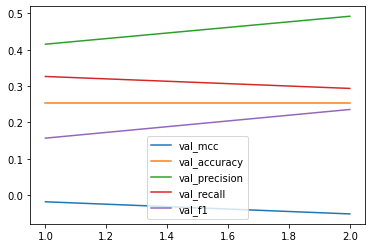


======== Epoch 1 / 2 ========
Training...
  Average training loss: 0.97
  Training epcoh took: 0:00:16

Running Validation...
  F1: 0.235
  MCC: -0.052
  Precision: 0.492
  Recall: 0.293
  Accuracy: 0.254
  Validation Loss: 1.11
  Validation took: 0:00:11
Saving model to ./model_save/0/

======== Epoch 2 / 2 ========
Training...
  Average training loss: 1.02
  Training epcoh took: 0:00:16

Running Validation...
  F1: 0.235
  MCC: -0.052
  Precision: 0.492
  Recall: 0.293
  Accuracy: 0.254
  Validation Loss: 1.11
  Validation took: 0:00:11
Saving model to ./model_save/1/

Training complete!
Total training took 0:01:03 (h:mm:ss)
mccs: [-0.052154061793796724, -0.052154061793796724]
accuracies: [0.25396825396825395, 0.25396825396825395]
precisions: [0.49226963512677796, 0.49226963512677796]
recalls: [0.29347826086956524, 0.29347826086956524]
f1_scores: [0.23546170604994132, 0.23546170604994132]
losses: [1.1089001893997192, 1.1089001893997192]


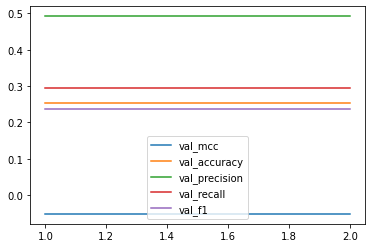

In [86]:
import warnings
warnings.filterwarnings ("ignore")

training_stats = trainer.train ()
training_stats = trainer.train (False)

In [87]:
predictions, true_labels, metrics_dummy = trainer.predict (test_dataset)
# The predictions for this batch are a 2-column ndarray (one column for "0" 
# and one column for "1"). Pick the label with the highest value and turn this
# in to a list of 0s and 1s.
pred_labels = np.argmax (predictions, axis=1)
pred_labels

Predicting labels for 63 test sentences...
Done predictions for  1 / 1 batches
Done prediction


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0],
      dtype=int64)

In [88]:
model.cpu()
del trainer, model, tokenizer
model = BertForSequenceClassification.from_pretrained ('./model_save/0/')
tokenizer = BertTokenizer.from_pretrained ('./model_save/0/', do_lower_case=False)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
submitDF = original_test_df[['id']]
submitDF['prediction'] = pred_labels
submitDF.prediction = submitDF.prediction.astype (int)
submitDF.to_csv ('submission.csv', index=False)
submitDF.head ()

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount ('/content/drive')

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "/content/drive/Shared_Drives/RishiChandra.ai/BERT_Fine-Tuning/"